# Exploratory data analysis on unlabeled data
We don't have labeled data yet, but we can still examine the data to see if there is something that stands out. 

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

For this chapter, we will be reading data from a SQLite database:

In [2]:
import sqlite3

with sqlite3.connect('logs/logs.db') as conn:
    logs_2018 = pd.read_sql(
        """
        SELECT * 
        FROM logs 
        WHERE datetime BETWEEN "2018-01-01" AND "2019-01-01";
        """, 
        conn, parse_dates=['datetime'], index_col='datetime'
    )
logs_2018.head()

,source_ip,username,success,failure_reason
datetime,,,,
2018-01-01 00:05:32.988414,223.178.55.3,djones,1,None
2018-01-01 00:08:00.343636,223.178.55.3,djones,0,error_wrong_password
2018-01-01 00:08:01.343636,223.178.55.3,djones,1,None
2018-01-01 01:06:59.640823,208.101.11.88,wbrown,1,None
2018-01-01 02:40:47.769630,11.76.99.35,tkim,1,None


## EDA
The `success` column is now an integer because SQLite doesn't have Booleans:

In [3]:
logs_2018.dtypes

source_ip         object
username          object
success            int64
failure_reason    object
dtype: object

We are working with data for all of 2018, so it's important to keep an eye on memory usage:

In [4]:
logs_2018.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38700 entries, 2018-01-01 00:05:32.988414 to 2018-12-31 23:29:42.482166
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source_ip       38700 non-null  object
 1   username        38700 non-null  object
 2   success         38700 non-null  int64 
 3   failure_reason  11368 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


The most common failure reason is providing the wrong password. We can also see that the unique usernames tried is well over the amount of users in our user base (133), indicating some suspicious activity:

In [5]:
logs_2018.describe(include='all')

,source_ip,username,success,failure_reason
count,38700,38700,38700.000000,11368
unique,4956,1797,NaN,3
top,168.123.156.81,wlopez,NaN,error_wrong_password
freq,314,387,NaN,6646
mean,NaN,NaN,0.706253,NaN
std,NaN,NaN,0.455483,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,0.000000,NaN
50%,NaN,NaN,1.000000,NaN
75%,NaN,NaN,1.000000,NaN


### Distinct users per IP address
Most IP addresses are associated with a single user, but at least one is associated with many:

In [6]:
logs_2018.groupby('source_ip').agg(dict(username='nunique'))\
    .username.describe()

count    4956.000000
mean        1.146287
std         1.916782
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       129.000000
Name: username, dtype: float64

### Calculate metrics per IP address
The top 5 rows of the pivot seem to be valid users, since they have relatively high success rates:

In [7]:
pivot = logs_2018.pivot_table(
    values='success', index='source_ip', 
    columns=logs_2018.failure_reason.fillna('success'), 
    aggfunc='count', fill_value=0
)
pivot.insert(0, 'attempts', pivot.sum(axis=1))
pivot = pivot.sort_values('attempts', ascending=False).assign(
    success_rate=lambda x: x.success / x.attempts,
    error_rate=lambda x: 1 - x.success_rate
)
pivot.head()

failure_reason,attempts,error_account_locked,error_wrong_password,error_wrong_username,success,success_rate,error_rate
source_ip,,,,,,,
168.123.156.81,314,0,37,0,277,0.882166,0.117834
24.112.17.125,309,0,37,0,272,0.880259,0.119741
16.118.156.50,289,0,41,1,247,0.854671,0.145329
25.246.225.197,267,0,43,0,224,0.838951,0.161049
30.67.241.95,265,0,37,0,228,0.860377,0.139623


### Visual Anomaly Detection
Let's see if something jumps out at us when plotting successes versus attempts by IP address:

<AxesSubplot:title={'center':'successes vs. attempts by IP address'}, xlabel='attempts', ylabel='success'>

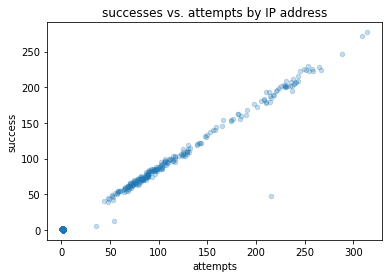

In [8]:
pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)

We can imagine there being a separation boundary between the groups by considering the fact that valid users probably have a close to 1:1 relationship between attempts and successes:

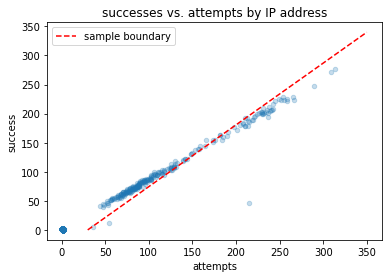

In [9]:
ax = pivot.plot(
    kind='scatter', x='attempts', y='success', 
    title='successes vs. attempts by IP address', alpha=0.25
)
ax.plot([30, 350], [0, 340], 'r--', label='sample boundary')
plt.legend()

More IP addresses are attacker IP addresses because they get a new IP address for each attack, while the valid users stick with the 1-3 they have. This makes the outliers on successes the valid users instead of the attackers.

attempts       AxesSubplot(0.125,0.125;0.352273x0.755)
success     AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

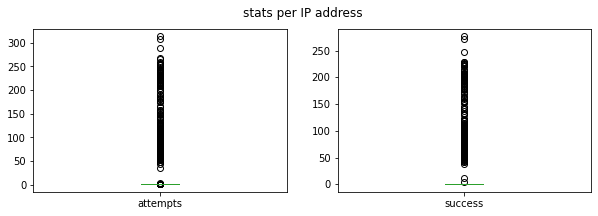

In [10]:
pivot[['attempts', 'success']].plot(
    kind='box', subplots=True, figsize=(10, 3),
    title='stats per IP address'
)

Does looking at this on a minute resolution make anything stand out?

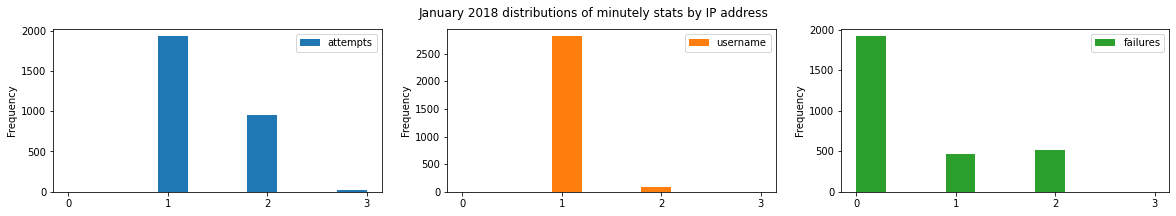

In [11]:
from matplotlib.ticker import MultipleLocator

ax = logs_2018.loc['2018-01'].assign(
    failures=lambda x: 1 - x.success
).groupby('source_ip').resample('1min').agg(
    {'username': 'nunique', 'success': 'sum', 'failures': 'sum'}
).assign(
    attempts=lambda x: x.success + x.failures
).dropna().query('attempts > 0').reset_index().plot(
    y=['attempts', 'username', 'failures'], kind='hist',
    subplots=True, layout=(1, 3), figsize=(20, 3),
    title='January 2018 distributions of minutely stats by IP address'
)
for axes in ax.flatten():
    axes.xaxis.set_major_locator(MultipleLocator(1))

There seems to be something with the number of usernames with failures per minute that we can use.

Text(0, 0.5, 'usernames with failures')

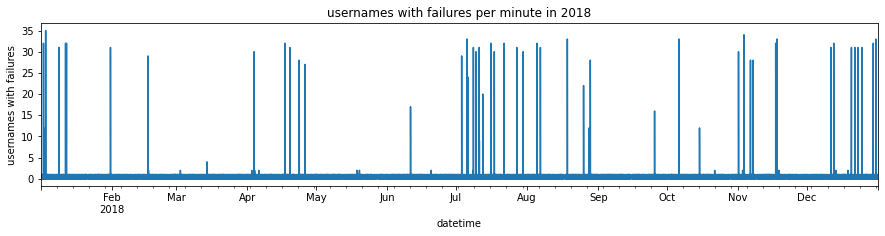

In [12]:
logs_2018.loc['2018'].assign(
    failures=lambda x: 1 - x.success
).query('failures > 0').resample('1min').agg(
    {'username': 'nunique', 'failures': 'sum'}
).dropna().rename(
    columns={'username': 'usernames_with_failures'}
).usernames_with_failures.plot(
    title='usernames with failures per minute in 2018',
    figsize=(15, 3)
).set_ylabel('usernames with failures')

<hr>
<div style="overflow: hidden; margin-bottom: 10px;">
    <div style="float: left;">
        <a href="../../ch_10/red_wine.ipynb">
            <button>&#8592; Chapter 10</button>
        </a>
        <a href="./0-simulating_the_data.ipynb">
            <button>Simulation</button>
        </a>
    </div>
    <div style="float: right;">
        <a href="./2-unsupervised_anomaly_detection.ipynb">
            <button>Next Notebook &#8594;</button>
        </a>
    </div>
</div>
<hr>